# Mushroom Classification
## Started 22/12/20

This is a look at developing a predictive model for classifying a mushroom as either poisonous or not. It is a Kaggle project: https://www.kaggle.com/uciml/mushroom-classification

I saw a highly reduced version of this database during one of my cousera courses, and so, as a first project, I thought I would give it a go from scratch, and in a lot more detail! This will also give me a chance to play around with a few different approaches.

### Import modules

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as ex
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1
from sklearn import tree
import scikitplot as skplt
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values

### Load data

In [34]:
df = pd.read_csv('../../data/mushrooms.csv')

In [35]:
print(df.shape)
df.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


So here we see a lot of letters! The obvious column, which is the taget, is class.

About this file
Attribute Information: (classes: edible=e, poisonous=p)

* cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
* cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
* cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
* bruises: bruises=t,no=f
* odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
* gill-attachment: attached=a,descending=d,free=f,notched=n
* gill-spacing: close=c,crowded=w,distant=d
* gill-size: broad=b,narrow=n
* gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
* stalk-shape: enlarging=e,tapering=t
* stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
* stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* veil-type: partial=p,universal=u
* veil-color: brown=n,orange=o,white=w,yellow=y
* ring-number: none=n,one=o,two=t
* ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
* spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
* population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
* habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

We see that some of the mushrooms in the sample are missing stalk roots. I will wait and see whether stalk-roots are an important feature before deciding what to do.

In [36]:
ex.pie(df,names='class',title='Class')

There is a fairly even distribution of poisonous and edible - no need to upsample.

Looking at the data, there only appears to be an ordinal relationship for ring number. So for the rest, I will one-hot encode the data. For ring number, I will just change the data to integers.

Let's now get the one-hot representations of the data.


In [37]:
df_ring = df['ring-number']
df_ring.replace({'n':0, 'o':1, 't':2}, inplace=True)

In [38]:
df = df.drop(columns=['ring-number'])
df_onehot = pd.get_dummies(df, drop_first=True)
# I am creating new dataframes, since the data is not too big and it makes it easier to run with small changes later

df_onehot['ring-number'] = df_ring

In [39]:
print('Number of columns = %i' %len(df_onehot.columns))

Number of columns = 95


In [41]:
df_onehot.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,ring-number
0,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [89]:
cut_correlation = 0.3
# A cut of 0.3 was found to give the best scores for both cross-validation
# on the training set and the test set score for the decision tree.

corr = df_onehot.corr('pearson')
cut_df_onehot = df_onehot[corr['class_p'][corr['class_p'].abs()>cut_correlation].index]

cut_df_onehot.head()

,class_p,bruises_t,odor_f,odor_n,gill-spacing_w,gill-size_n,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-below-ring_k,stalk-surface-below-ring_s,ring-type_l,ring-type_p,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_w,population_v,habitat_p
0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0
2,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0
3,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0
4,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0


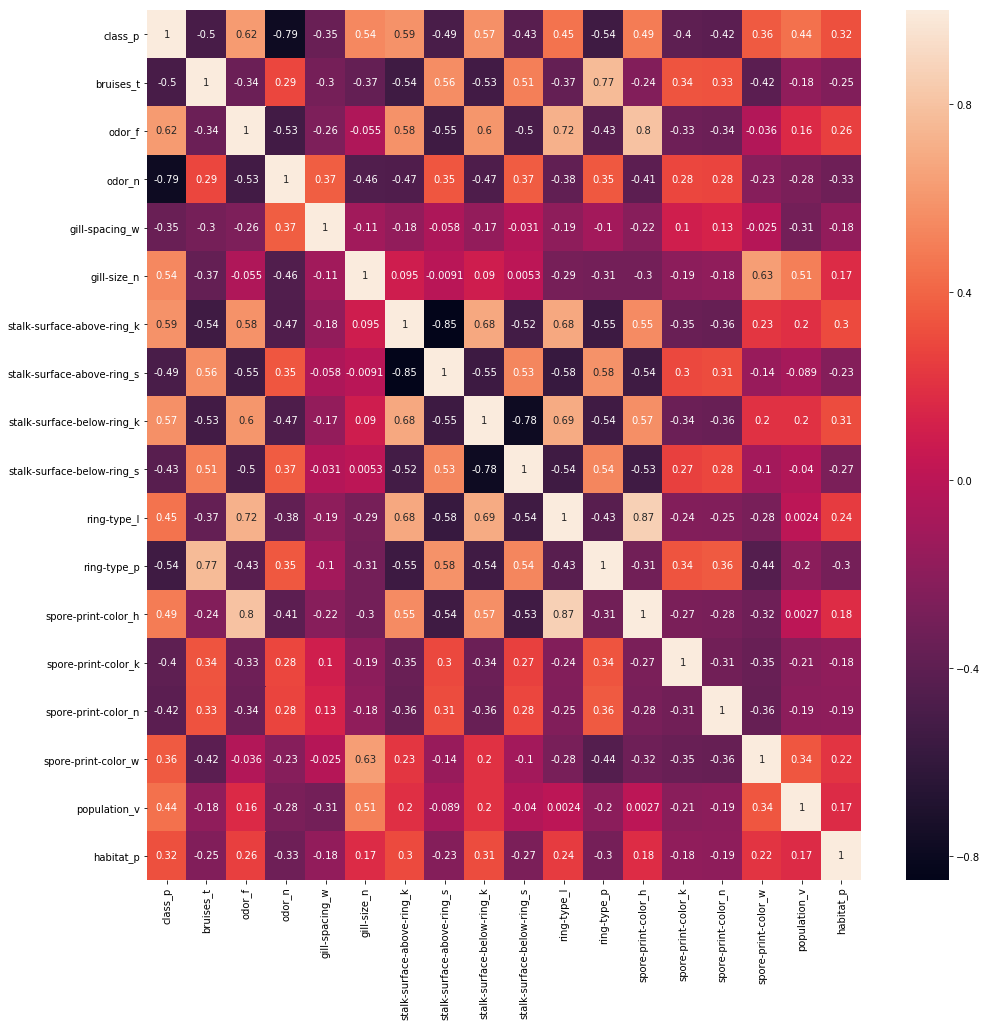

In [90]:
plt.figure(figsize=(16,16))

sns.heatmap(cut_df_onehot.corr('pearson'),annot=True)

Stalk root has not made the cut, so we can forget about the missing information

In [91]:
X_train, X_test, y_train, y_test = train_test_split(cut_df_onehot.drop('class_p', 1), cut_df_onehot['class_p'], test_size = 0.1, random_state=10)

In [92]:
print('number of samples in test data = %i' %(len(y_test)))

clf = DecisionTreeClassifier(max_depth=7)

number of samples in test data = 813


800 samples in the test data seems like enough to me!

In [93]:
model = clf.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[3778,    0],
       [   0, 3533]])

After a few iterations with various max_depths, at max_depth = 7, we have a 100% result for the training data. Let's have a look at the decsion tree...

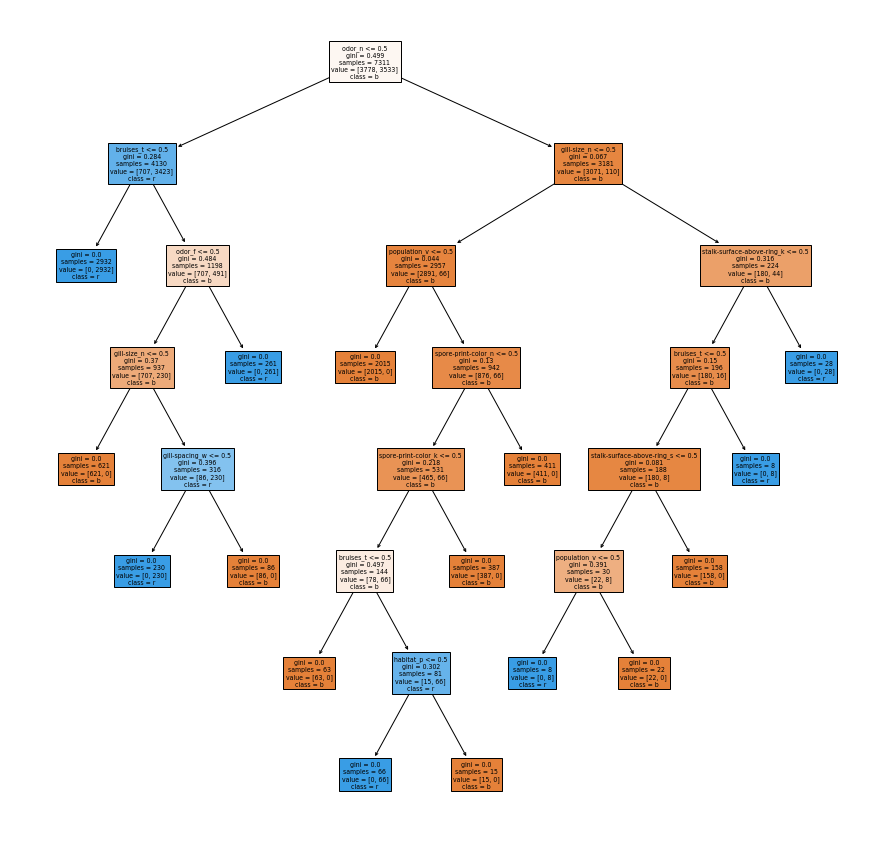

In [94]:
fig = plt.figure(figsize=(15,15))
_ = tree.plot_tree(model, 
                   feature_names=list(cut_df_onehot.columns[1:]),
                   class_names=list(cut_df_onehot.columns[1]),
                   filled=True)

For me, this looks quite complex, but I have not seen that many! The first decision asks whether the mushrooms have an odor or not. Given the complexity, it may be that we are overfitting to the training data. Let's look at the test data now.

In [95]:
y_pred = model.predict(X_test)

In [96]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[430,   0],
       [  0, 383]])

Again 100%. Seems like this is almost a perfect classifier, given this dataset. For good practice, I will just compute the F1 scores from the training data using cross-validation and compare to the test data (which we know from the confusion matrix is 1.0!)

In [97]:
f1_train = cross_val_score(model ,X_train, y_train, cv=5, scoring='f1')
print('F1 train score = ', np.mean(f1_train))

recall_train = cross_val_score(model ,X_train, y_train, cv=5, scoring='recall')
print('Recall train score = ', np.mean(recall_train))

F1 train score =  1.0
Recall train score =  1.0


So the cross-validation confirms what we already know!

In [98]:
print('F1 test score - {}'.format(f1(y_pred ,y_test)))

F1 test score - 1.0


Probably not much point on plotting the precision-recall curve with an F1 score of 1.0, but let's do it for good practice

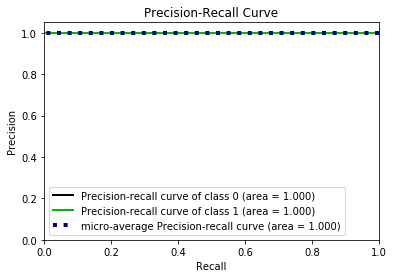

In [99]:
y_pred_quant = model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_pred_quant)

The decision tree has done well! Let's have a look at the main predictors of whether the mushrooms are poisonous...

In [100]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2455 ± 0.0267,odor_n
0.1506 ± 0.0195,gill-size_n
0.0959 ± 0.0127,bruises_t
0.0507 ± 0.0067,odor_f
0.0403 ± 0.0069,spore-print-color_k
0.0401 ± 0.0111,spore-print-color_n
0.0162 ± 0.0059,gill-spacing_w
0.0135 ± 0.0035,population_v
0.0081 ± 0.0030,stalk-surface-above-ring_k
0.0027 ± 0.0053,stalk-surface-above-ring_s


Odor and gill size seem to have the strongest effect on the accuracy of the model. From this, there appears to be a few things at the bottom that don't have any impact on the accuracy. Could these be removed from the fit with no loss of accuracy for the model? I think so, a quick look at the decision tree above and I can't see those mentioned in the decisions.

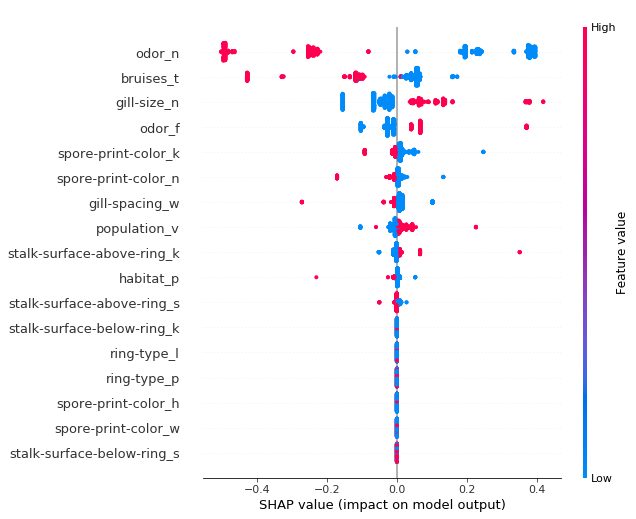

In [101]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

So here we see that no odor is a strong indication of edible and foul odor is a strong indicator of poisonous. 

Lets have a look at using random permutations...

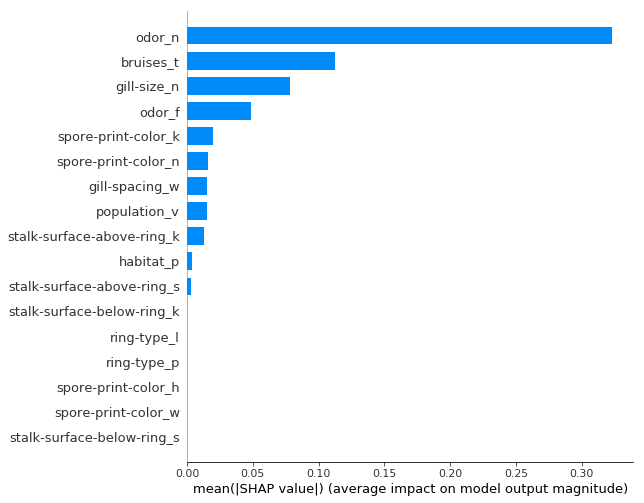

In [102]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

Finally, lets look at a couple of individual cases. Just for fun!

In [103]:
def class_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [104]:
data_for_prediction = X_test.iloc[4,:].astype(float)
class_factors(model, data_for_prediction)

So this is predicted to be certainly poisonous. It has an odor and a narrow gill size.

In [105]:
data_for_prediction = X_test.iloc[10,:].astype(float)
class_factors(model, data_for_prediction)

This is not poisonous. It has no odor and doesn't have a narrow gill size

As a bit of an exercise, let's look at using a Naive Bayes Classifier. We will do this using the already cut data, since we know that we can achieve 100% with this using a decision tree.

In [106]:
clf_nb = GaussianNB()
clf_ada = AdaBoostClassifier()
clf_svc = SVC()

In [107]:
model_nb = clf_nb.fit(X_train, y_train)
model_ada = clf_ada.fit(X_train, y_train)
model_svc = clf_svc.fit(X_train, y_train)

In [108]:
y_pred_nb = model_nb.predict(X_test)
y_pred_ada = model_ada.predict(X_test) 
y_pred_svc = model_svc.predict(X_test)

In [109]:
f1_train = cross_val_score(model_nb ,X_train, y_train, cv=5, scoring='f1')
print('F1 NB train score = ', np.mean(f1_train))
f1_train = cross_val_score(model_ada ,X_train, y_train, cv=5, scoring='f1')
print('F1 ADA train score = ', np.mean(f1_train))
f1_train = cross_val_score(model_svc ,X_train, y_train, cv=5, scoring='f1')
print('F1 SVC train score = ', np.mean(f1_train))

F1 NB train score =  0.8827188625493345
F1 ADA train score =  0.9633737795091996
F1 SVC train score =  1.0


In [110]:
print('F1 NB test score - {}'.format(f1(y_pred_nb ,y_test)))
print('F1 ADA test score - {}'.format(f1(y_pred_ada ,y_test)))
print('F1 SVC test score - {}'.format(f1(y_pred_svc ,y_test)))

F1 NB test score - 0.8775510204081632
F1 ADA test score - 0.9681697612732096
F1 SVC test score - 1.0


OK, so we see that SVC has also achieved 100% accuracy, with no tuning of the parameters! Let's have a look at the most important features using permutations... 

In [111]:
perm = PermutationImportance(model_svc, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1159 ± 0.0191,gill-size_n
0.1082 ± 0.0104,spore-print-color_k
0.0908 ± 0.0191,spore-print-color_n
0.0721 ± 0.0157,odor_n
0.0251 ± 0.0077,bruises_t
0.0175 ± 0.0055,gill-spacing_w
0.0039 ± 0.0010,stalk-surface-above-ring_k
0.0034 ± 0.0018,spore-print-color_w
0.0032 ± 0.0012,population_v
0 ± 0.0000,odor_f


Interestingly, more weight has been given to gill-size and spore print color than odor here!

### Conclusion

An almost perfect level of accuracy for predicting whether a mushroom is poisonous can be acieved using either a Decision Tree (with a bit of fine tuning) or an SVC model (here we just used the default parameters in SKLearn). Overall, the top features are pretty much the same in both cases - odor (y/n), spore-print-color, a narrow gill-size (y/n) and bruises (y/n) appear to be the best indicator of whether a mushroom is poisonous or not. No odor indicates it is edible; if the spores are black or brown, the mushroom is more likely to be edible; while a narrow gill indicates poisonous and no bruies indicate poisionous. 